# Importing Libraries

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import itertools
import numpy as np
from torchsummary import summary
from torchvision import models
import torch.nn.functional as F

# Set Device (GPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Data Transformations for Training and Testing

In [3]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Loading CIFAR-10 Dataset

Files already downloaded and verified
Files already downloaded and verified


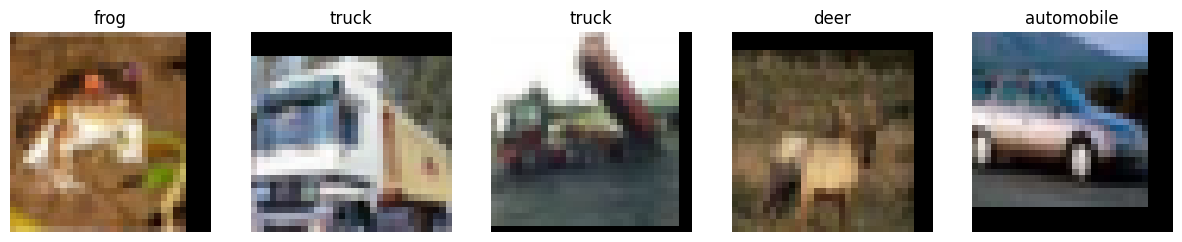

In [4]:
# Load CIFAR-10 dataset
trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Display sample images 
def show_images(dataset, classes, mean=mean, std=std):
    fig, axs = plt.subplots(1, 5, figsize=(15, 3))
    for i in range(5):
        img, label = dataset[i]
        img = img * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
        npimg = np.clip(img.numpy(), 0, 1)
        axs[i].imshow(np.transpose(npimg, (1, 2, 0)))
        axs[i].set_title(classes[label])
        axs[i].axis('off')
    plt.show()

show_images(trainset_full, classes)

# Split Dataset into Training and Validation Sets (80-20 split)

In [5]:
# Split into Training and Validation Sets (80-20 split)
train_size = int(0.8 * len(trainset_full))
val_size = len(trainset_full) - train_size
trainset, valset = random_split(trainset_full, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Dataset Summary and Class Display

In [6]:
def dataset_summary():
    print("Dataset Summary:")
    print(f"Total training samples: {len(trainset_full)}")
    print(f"Training set size: {len(trainset)}")
    print(f"Validation set size: {len(valset)}")
    print(f"Test set size: {len(testset)}")
    print("Classes:", trainset_full.classes)

dataset_summary()

Dataset Summary:
Total training samples: 50000
Training set size: 40000
Validation set size: 10000
Test set size: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [46]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Epoch [1/10], Loss: 2.1198, Train Accuracy: 24.10%, Validation Accuracy: 32.41%
Epoch [2/10], Loss: 1.8288, Train Accuracy: 34.57%, Validation Accuracy: 38.93%
Epoch [3/10], Loss: 1.6790, Train Accuracy: 39.48%, Validation Accuracy: 41.33%
Epoch [4/10], Loss: 1.5793, Train Accuracy: 42.66%, Validation Accuracy: 43.80%
Epoch [5/10], Loss: 1.5188, Train Accuracy: 44.86%, Validation Accuracy: 45.98%
Epoch [6/10], Loss: 1.4745, Train Accuracy: 46.64%, Validation Accuracy: 47.60%
Epoch [7/10], Loss: 1.4393, Train Accuracy: 48.23%, Validation Accuracy: 49.63%
Epoch [8/10], Loss: 1.4060, Train Accuracy: 49.41%, Validation Accuracy: 50.13%
Epoch [9/10], Loss: 1.3721, Train Accuracy: 50.66%, Validation Accuracy: 52.45%
Epoch [10/10], Loss: 1.3459, Train Accuracy: 51.83%, Validation Accuracy: 52.17%


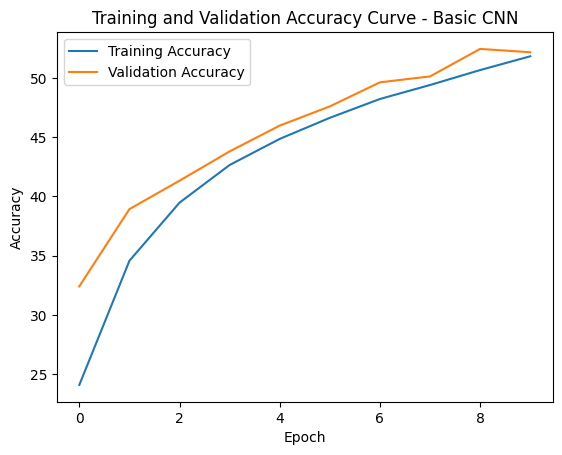

Test Accuracy: 54.31%
Test Accuracy for Basic CNN: 54.31%


In [49]:
# Instantiate the model, define the loss function and optimizer
model = BasicCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Train the model and track accuracy
train_acc, val_acc = train_model_with_validation(model, criterion, optimizer, num_epochs=10)

# Plot the training and validation accuracy
plot_training_and_validation_accuracy(train_acc, val_acc, "Basic CNN")

# Evaluate the model on the test set
test_accuracy = evaluate_model(model, testloader)
print(f"Test Accuracy for Basic CNN: {test_accuracy:.2f}%")

In [50]:
class OptimizedCNN(nn.Module):
    def __init__(self):
        super(OptimizedCNN, self).__init__()
        
        # Convolutional Layers with Batch Normalization and Dropout
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Pooling and Dropout Layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 4 * 4, 256)  # Increased number of neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)  # Output layer for 10 classes

    def forward(self, x):
        # Convolutional Layer 1
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Convolutional Layer 2
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Convolutional Layer 3
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten for Fully Connected Layers
        x = x.view(-1, 128 * 4 * 4)
        
        # Fully Connected Layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        
        # Output Layer
        x = self.fc3(x)
        
        return x

In [51]:
# Instantiate the model, define the loss function and optimizer
model_optimized = OptimizedCNN().to(device)
criterion = nn.CrossEntropyLoss()

# Use SGD with momentum and weight decay
optimizer = torch.optim.SGD(model_optimized.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Learning rate scheduler to reduce LR on plateau in validation accuracy
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, verbose=True)


Epoch [1/10], Loss: 0.8757, Train Accuracy: 69.51%, Validation Accuracy: 72.27%
Epoch [2/10], Loss: 0.8368, Train Accuracy: 70.81%, Validation Accuracy: 72.53%
Epoch [3/10], Loss: 0.8043, Train Accuracy: 71.86%, Validation Accuracy: 72.64%
Epoch [4/10], Loss: 0.7738, Train Accuracy: 72.99%, Validation Accuracy: 74.03%
Epoch [5/10], Loss: 0.7460, Train Accuracy: 73.91%, Validation Accuracy: 74.94%
Epoch [6/10], Loss: 0.7215, Train Accuracy: 75.28%, Validation Accuracy: 76.29%
Epoch [7/10], Loss: 0.7093, Train Accuracy: 75.49%, Validation Accuracy: 76.68%
Epoch [8/10], Loss: 0.6774, Train Accuracy: 76.55%, Validation Accuracy: 77.48%
Epoch [9/10], Loss: 0.6699, Train Accuracy: 76.94%, Validation Accuracy: 76.43%
Epoch [10/10], Loss: 0.6534, Train Accuracy: 77.54%, Validation Accuracy: 78.27%


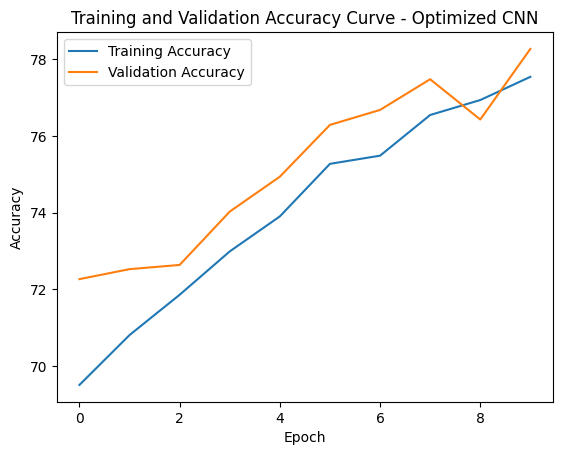

Test Accuracy: 78.56%
Test Accuracy for Optimized CNN: 78.56%


In [53]:
# Train the model and track accuracy
train_acc_optimized, val_acc_optimized = train_model_with_validation(
    model_optimized, criterion, optimizer, scheduler=scheduler, num_epochs=10
)

# Plot the training and validation accuracy for the optimized model
plot_training_and_validation_accuracy(train_acc_optimized, val_acc_optimized, "Optimized CNN")

# Evaluate the optimized model on the test set
test_accuracy_optimized = evaluate_model(model_optimized, testloader)
print(f"Test Accuracy for Optimized CNN: {test_accuracy_optimized:.2f}%")

In [7]:
# Function to define and summarise ResNet-18
def resnet18_summary():
    print("\nResNet-18 Model Summary:")
    model = models.resnet18(weights=None)  # Use ResNet-18 without pretrained weights
    model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for 10 classes (CIFAR-10)
    model = model.to(device)
    summary(model, (3, 32, 32))

# Function to define and summarize AlexNet
def alexnet_summary():
    print("\nAlexNet Model Summary:")
    model = models.alexnet(weights=None)
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)  # Adjust for 32x32 input
    model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)  # Adjust for 10 classes
    model = model.to(device)
    summary(model, (3, 32, 32))

# Function to define and summarize MobileNetV2
def mobilenet_v2_summary():
    print("\nMobileNetV2 Model Summary:")
    model = models.mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)  # Adjust for 10 classes
    model = model.to(device)
    summary(model, (3, 32, 32))

# Define ResNet-18 & MobileNetV2 Model

In [8]:
def get_resnet18():
    model = torchvision.models.resnet18(weights=None)
    num_features = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for 10 CIFAR-10 classes

    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Add dropout with 50% probability
        nn.Linear(num_features, 10)  # Final layer for 10 classes (CIFAR-10)
    )
    
    return model.to(device)
    

def get_mobilenet_v2():
    model = torchvision.models.mobilenet_v2(weights=None)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 10)
    return model.to(device)

# Plot Training and Validation Accuracy Curves

In [9]:
def plot_training_and_validation_accuracy(train_acc, val_acc, model_name):
    plt.plot(train_acc, label="Training Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Training and Validation Accuracy Curve - {model_name}")
    plt.legend()
    plt.show()

# Evaluate Model on Test Set

In [10]:
def evaluate_model(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")
    return accuracy

# Training Function with Validation

In [23]:
# Training function with validation
def train_model_with_validation(model, criterion, optimizer, num_epochs=10):
    train_acc, val_acc = [], []
    for epoch in range(num_epochs):
        # Training
        model.train()
        correct_train, total_train, running_loss = 0, 0, 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Accuracy and loss tracking
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            running_loss += loss.item()

        # Calculate training accuracy
        epoch_loss = running_loss / len(trainloader)
        epoch_accuracy = 100 * correct_train / total_train
        train_acc.append(epoch_accuracy)
        
        # Validation
        model.eval()
        correct_val, total_val = 0, 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct_val / total_val
        val_acc.append(val_accuracy)
        
        # Print epoch results
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")
        
    return train_acc, val_acc

In [49]:
# Display model summaries
resnet18_summary()


ResNet-18 Model Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             

# Baseline Training for ResNet-18

Training ResNet-18 Baseline...
Epoch [1/10], Loss: 2.0309, Train Accuracy: 27.00%, Validation Accuracy: 38.15%
Epoch [2/10], Loss: 1.6562, Train Accuracy: 38.73%, Validation Accuracy: 43.85%
Epoch [3/10], Loss: 1.5311, Train Accuracy: 43.43%, Validation Accuracy: 47.30%
Epoch [4/10], Loss: 1.4429, Train Accuracy: 47.42%, Validation Accuracy: 50.81%
Epoch [5/10], Loss: 1.3747, Train Accuracy: 50.13%, Validation Accuracy: 52.86%
Epoch [6/10], Loss: 1.3068, Train Accuracy: 52.62%, Validation Accuracy: 55.21%
Epoch [7/10], Loss: 1.2606, Train Accuracy: 54.42%, Validation Accuracy: 55.18%
Epoch [8/10], Loss: 1.2200, Train Accuracy: 56.04%, Validation Accuracy: 56.49%
Epoch [9/10], Loss: 1.1823, Train Accuracy: 57.13%, Validation Accuracy: 58.60%
Epoch [10/10], Loss: 1.1492, Train Accuracy: 58.60%, Validation Accuracy: 60.12%


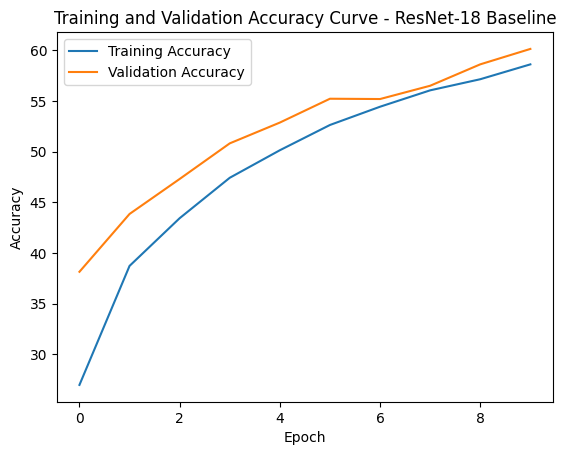

Evaluating ResNet-18 Baseline Model on Test Set...
Test Accuracy: 62.67%


62.67

In [33]:
# Baseline Training for ResNet-18 
print("Training ResNet-18 Baseline...")
resnet18_baseline = get_resnet18()
criterion = nn.CrossEntropyLoss()
optimizer_resnet18 = optim.SGD(resnet18_baseline.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4) #  lr=0.001, momentum=0.9, weight_decay=5e-4
train_acc_resnet18, val_acc_resnet18 = train_model_with_validation(resnet18_baseline, criterion, optimizer_resnet18, num_epochs=10)  # 10 epochs 
plot_training_and_validation_accuracy(train_acc_resnet18, val_acc_resnet18, "ResNet-18 Baseline")
print("Evaluating ResNet-18 Baseline Model on Test Set...")
evaluate_model(resnet18_baseline, testloader)

# Baseline Training for MobileNetV2


Training MobileNetV2 Baseline...
Epoch [1/10], Loss: 2.2210, Train Accuracy: 16.04%, Validation Accuracy: 21.63%
Epoch [2/10], Loss: 1.9493, Train Accuracy: 26.17%, Validation Accuracy: 30.96%
Epoch [3/10], Loss: 1.8167, Train Accuracy: 31.12%, Validation Accuracy: 33.46%
Epoch [4/10], Loss: 1.7334, Train Accuracy: 34.59%, Validation Accuracy: 36.99%
Epoch [5/10], Loss: 1.6726, Train Accuracy: 37.53%, Validation Accuracy: 38.94%
Epoch [6/10], Loss: 1.6254, Train Accuracy: 39.24%, Validation Accuracy: 41.82%
Epoch [7/10], Loss: 1.5826, Train Accuracy: 40.88%, Validation Accuracy: 43.47%
Epoch [8/10], Loss: 1.5489, Train Accuracy: 42.52%, Validation Accuracy: 44.34%
Epoch [9/10], Loss: 1.5196, Train Accuracy: 43.92%, Validation Accuracy: 45.81%
Epoch [10/10], Loss: 1.4856, Train Accuracy: 45.13%, Validation Accuracy: 46.38%


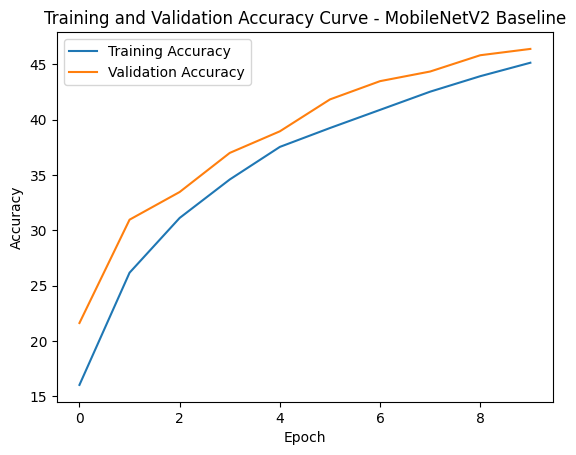

Evaluating MobileNetV2 Baseline Model on Test Set...
Test Accuracy: 48.96%


48.96

In [38]:
print("\nTraining MobileNetV2 Baseline...")
mobilenet_v2_baseline = get_mobilenet_v2()
optimizer_mobilenet_v2 = optim.SGD(mobilenet_v2_baseline.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
train_acc_mobilenet_v2, val_acc_mobilenet_v2 = train_model_with_validation(mobilenet_v2_baseline, criterion, optimizer_mobilenet_v2, num_epochs=10)
plot_training_and_validation_accuracy(train_acc_mobilenet_v2, val_acc_mobilenet_v2, "MobileNetV2 Baseline")
print("Evaluating MobileNetV2 Baseline Model on Test Set...")
evaluate_model(mobilenet_v2_baseline, testloader)

In [37]:
# Model's summary
# mobilenet_v2_summary()

# Hyperparameter Tuning for ResNet-18

In [34]:
# Hyperparameters taken 
learning_rate = 0.01
weight_decay = 0.0001
optimizer_type = 'Adam'

# Function to set optimiser with updated hyperparameters
def get_optimizer(model):
    return optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

# Improved training function for ResNet-18 with dropout
def improved_training(model_fn, model_name, num_epochs=10):
    print(f"\nTraining {model_name} with adjusted configuration: lr={learning_rate}, optimizer={optimizer_type}, weight_decay={weight_decay}") 
    model = model_fn()  # Use the modified ResNet-18 with dropout
    optimizer = get_optimizer(model)
    criterion = nn.CrossEntropyLoss()
    train_acc, val_acc = train_model_with_validation(model, criterion, optimizer, num_epochs=num_epochs)  
    test_accuracy = evaluate_model(model, testloader) 
    plot_training_and_validation_accuracy(train_acc, val_acc, f"{model_name}")  # Plot training and validation accuracy for the adjusted configuration
    print(f"Test Accuracy for {model_name}: {test_accuracy:.2f}%")

Optimisation for ResNet-18 

Training ResNet-18 with adjusted configuration: lr=0.01, optimizer=Adam, weight_decay=0.0001
Epoch [1/10], Loss: 1.9281, Train Accuracy: 32.25%, Validation Accuracy: 41.40%
Epoch [2/10], Loss: 1.5858, Train Accuracy: 44.19%, Validation Accuracy: 48.52%
Epoch [3/10], Loss: 1.4346, Train Accuracy: 50.22%, Validation Accuracy: 54.10%
Epoch [4/10], Loss: 1.2861, Train Accuracy: 55.24%, Validation Accuracy: 57.55%
Epoch [5/10], Loss: 1.2065, Train Accuracy: 58.97%, Validation Accuracy: 62.12%
Epoch [6/10], Loss: 1.1078, Train Accuracy: 61.87%, Validation Accuracy: 62.55%
Epoch [7/10], Loss: 1.0480, Train Accuracy: 63.49%, Validation Accuracy: 64.93%
Epoch [8/10], Loss: 0.9821, Train Accuracy: 65.92%, Validation Accuracy: 66.18%
Epoch [9/10], Loss: 0.9307, Train Accuracy: 67.58%, Validation Accuracy: 66.69%
Epoch [10/10], Loss: 0.8938, Train Accuracy: 68.71%, Validation Accuracy: 68.89%
Test Accuracy: 69.67%


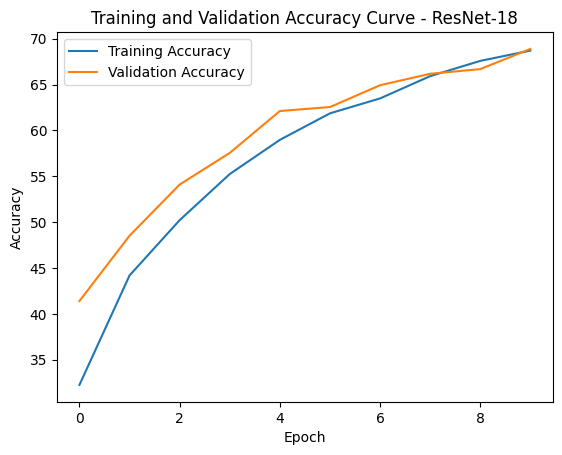

Test Accuracy for ResNet-18: 69.67%


In [35]:
print("Optimisation for ResNet-18 ")
improved_training(get_resnet18, "ResNet-18")

# # Hyperparameter Tuning for MobileNetV2

In [40]:
# Hyperparameters chosen for MobileNetV2
learning_rate = 0.01
weight_decay =  0.0005
optimizer_type = 'Adam'

# Improved training function for MobileNetV2
def improved_training_for_MobileNetV2(model_fn, model_name, num_epochs=10):
    print(f"\nTraining {model_name} with Hyperparameters chosen: lr={learning_rate}, optimizer={optimizer_type}, weight_decay={weight_decay}")  
    model = model_fn()
    optimizer = get_optimizer(model)  
    criterion = nn.CrossEntropyLoss()
    train_acc, val_acc = train_model_with_validation(model, criterion, optimizer, num_epochs=num_epochs)    
    test_accuracy = evaluate_model(model, testloader)   
    plot_training_and_validation_accuracy(train_acc, val_acc, f"{model_name} (Adjusted)")  # Plotting training and validation accuracy for the adjusted configuration
    print(f"Test Accuracy for {model_name}: {test_accuracy:.2f}%")


 Optimisation for MobileNetV2

Training MobileNetV2 with Hyperparameters chosen: lr=0.01, optimizer=Adam, weight_decay=0.0005
Epoch [1/10], Loss: 2.0618, Train Accuracy: 23.90%, Validation Accuracy: 31.32%
Epoch [2/10], Loss: 1.7527, Train Accuracy: 35.19%, Validation Accuracy: 38.30%
Epoch [3/10], Loss: 1.6020, Train Accuracy: 40.95%, Validation Accuracy: 41.79%
Epoch [4/10], Loss: 1.4996, Train Accuracy: 45.10%, Validation Accuracy: 47.01%
Epoch [5/10], Loss: 1.4370, Train Accuracy: 47.61%, Validation Accuracy: 50.75%
Epoch [6/10], Loss: 1.3823, Train Accuracy: 49.84%, Validation Accuracy: 52.40%
Epoch [7/10], Loss: 1.3284, Train Accuracy: 52.04%, Validation Accuracy: 53.23%
Epoch [8/10], Loss: 1.2844, Train Accuracy: 53.61%, Validation Accuracy: 55.13%
Epoch [9/10], Loss: 1.2350, Train Accuracy: 55.78%, Validation Accuracy: 56.34%
Epoch [10/10], Loss: 1.1907, Train Accuracy: 57.40%, Validation Accuracy: 57.76%
Test Accuracy: 59.73%


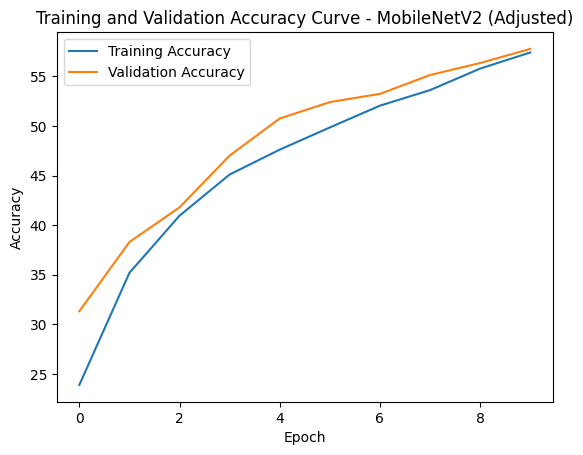

Test Accuracy for MobileNetV2: 59.73%


In [41]:
print("\n Optimisation for MobileNetV2")
improved_training_for_MobileNetV2(get_mobilenet_v2, "MobileNetV2")

# Define AlexNet

In [61]:
# Function to create AlexNet model for CIFAR-10
def get_alexnet():
    model = models.alexnet(weights=None)
    
    # Modify the first convolutional layer to handle 32x32 images
    model.features[0] = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    
    # Calculate flattened size after feature extraction layers
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    features_output = model.features(dummy_input)
    flattened_size = features_output.view(-1).shape[0]
    
    # Modify fully connected layers to accommodate CIFAR-10's 10 classes
    model.classifier[1] = nn.Linear(flattened_size, 4096)
    model.classifier[6] = nn.Linear(4096, 10)  # Output layer for 10 classes
    
    return model.to(device)  # Move model to the appropriate device


In [62]:
# Training function with device handling
def train_model_with_loss_tracking(model, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            # Move inputs and labels to the correct device
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_loss / len(trainloader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in valloader:
                # Move inputs and labels to the correct device
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
        
        epoch_val_loss = running_loss / len(valloader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}")
    
    return train_losses, val_losses


In [39]:
# Model's summary
# alexnet_summary()

# Baseline Training for AlexNet

In [63]:
# Initialize and train AlexNet model
print("Training AlexNet...")
alexnet_model = get_alexnet()  # Move AlexNet to the appropriate device
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet_model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Train the model and get loss values for learning curve
train_losses, val_losses = train_model_with_loss_tracking(alexnet_model, criterion, optimizer, num_epochs=10)

# Plot the learning curve
plot_learning_curve(train_losses, val_losses)

Training AlexNet...


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

# Hyperparameter Tuning for AlexNet

In [19]:
print("Hyperparameter Tuning for AlexNet")
alexnet_tuned = get_alexnet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(alexnet_tuned.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler - Reduce on plateau
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5, verbose=True)

# Train and validate with improved configuration
train_acc, val_acc = train_model_with_validation(
    model=alexnet_tuned, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=10, 
    scheduler=scheduler
)
plot_training_and_validation_accuracy(train_acc, val_acc, "AlexNet (Improved with Scheduler)")
print("Evaluating AlexNet with Hyperparameter Tuning on Test Set...")
evaluate_model(alexnet_tuned, testloader)

Hyperparameter Tuning for AlexNet


E:\Codes_data\try\envs\ai\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x9216 and 4096x4096)

In [18]:
torch.cuda.empty_cache()
print(torch.cuda.memory_summary(device=None, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      | 296269 KiB | 331421 KiB |    799 MiB | 522517 KiB |
|---------------------------------------------------------------------------|
| Active memory         | 296269 KiB | 331421 KiB |    799 MiB | 522517 KiB |
|---------------------------------------------------------------------------|
| Requested memory      | 296220 KiB | 331420 KiB |    799 MiB | 522515 KiB |
|---------------------------------------------------------------